Test in python to test the optical flow estimation from the time difference between pixels

In [1]:
%load_ext autoreload
%autoreload 2
import utils
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
from tqdm import tqdm
from multiprocessing import Pool
import numpy.ma as ma
from scipy.ndimage import gaussian_filter, convolve

In [2]:
event_data = np.loadtxt("./data/events.txt")
position_data = np.loadtxt("./data/groundtruth.txt")

In [3]:
#params
t_start = 2.6
duration = 0.1

img_height = 180
img_width = 240

Filter to events to be in the specified time range

In [4]:
events_range = utils.get_events_range(event_data, t_start, duration)

Bins the events in 3x3 cells (specified by cell_shape).
When 66% of the pixels in that cell register an event, the cell itself also fires.
The binning should also be limited by time. In other words the 66% of the pixels should fire close to each other in time.
//
The first value for each cell is the count of events received, the second is the time when cell itself should fire.

In [5]:
depth_img = np.full((img_height, img_width, 3), -1.0)
cell_shape = (3, 3)
sampled_img = np.zeros((int(img_height/cell_shape[0]), int(img_width/cell_shape[1]), 2))
for e in events_range:
    
    x = int(e[1] / cell_shape[0])
    y = int(e[2] / cell_shape[1])
    
    #pos = float(utils.get_interpolated_position(e[0], position_data))*10
    pos = e[0]*10
    sampled_img[y, x, 0] += 1
    
    if sampled_img[y, x, 0] >= cell_shape[0]*cell_shape[1]*0.66 and sampled_img[y, x, 1] == 0:
        sampled_img[y, x, 1] = pos

Measure the difference between 2 adjacent cells in the direction opposite to the motio of the camera. Take the exp of the diff to show more the difference.

In [6]:
sampled_diff = np.full(sampled_img[:,:,1].shape, -1.0)
for y in range(sampled_diff.shape[0]):
    for x in range(sampled_diff.shape[1] -1):
        if np.isclose(sampled_img[y,x+1,1], 0.0):
            continue
        if sampled_img[y,x,1] <= sampled_img[y,x+1,1]:
            continue
        sampled_diff[y, x] = np.exp(sampled_img[y,x,1] - sampled_img[y,x+1,1])

(array([3.512e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.700e+01, 6.100e+01, 1.250e+02, 1.650e+02, 1.620e+02, 1.160e+02,
        9.200e+01, 7.800e+01, 5.300e+01, 4.200e+01, 4.500e+01, 3.900e+01,
        2.300e+01, 2.000e+01, 2.000e+01, 2.500e+01, 2.500e+01, 2.900e+01,
        3.100e+01, 2.400e+01, 2.100e+0

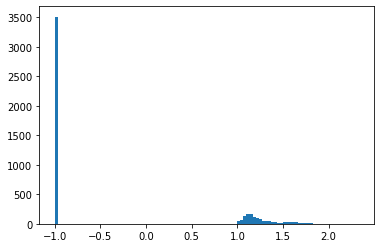

In [7]:
plt.hist(sampled_diff.flatten(), 100)

2.3327317366638245


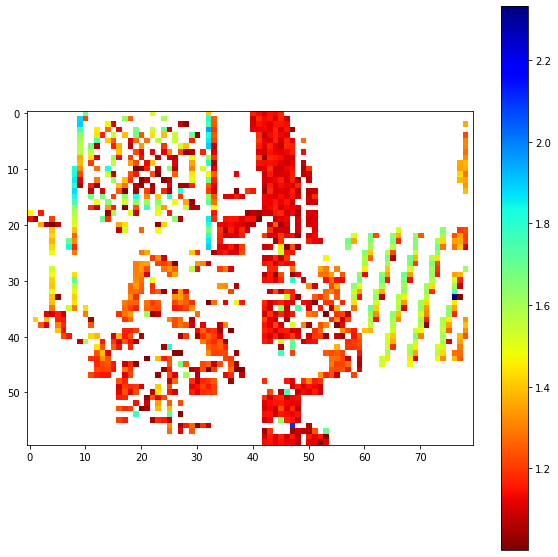

In [8]:
plt.figure(figsize=(10, 10))
sampled_diff_m = ma.masked_where(np.logical_or(sampled_diff <= 0, sampled_diff>6.8), sampled_diff)
m = plt.imshow(sampled_diff_m, cmap="jet_r")
plt.colorbar(mappable=m)
print(sampled_diff_m.max())

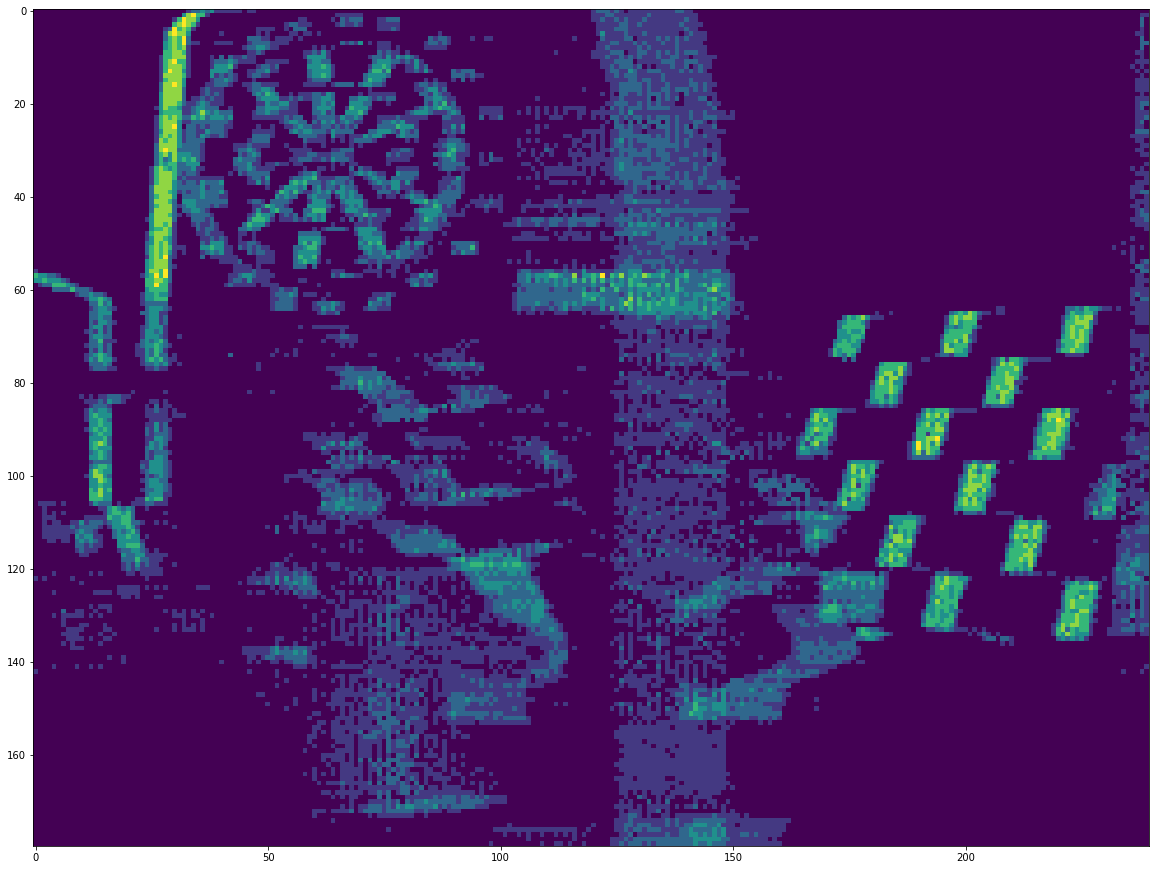

In [30]:
def img_from_events(events):
    img = np.zeros((img_height, img_width))
    for e in events:
        if e[3] == 1:
            continue
        x = int(e[1])
        y = int(e[2])
        img[y, x] += 1
    return img
plt.figure(figsize=(20, 20))
plt.imshow(img_from_events(events_range))

Similar to before, but the sampling is done with overlapping cells, like a convolution. Each pixel has a corresponding bin centered around it.

In [52]:
depth_img = np.full((img_height, img_width, 3), -1.0)
cell_shape = (3, 3)
sampled_img = np.zeros((img_height, img_width, 2))
for e in events_range:
    
    x = int(e[1])
    y = int(e[2])
    
    if x == 0 or x >= img_width - int(cell_shape[0]/2):
        continue
    if y == 0 or y >= img_height - int(cell_shape[1]/2):
        continue
        
    pos = e[0]*10
        
    for a in range(x-int(cell_shape[0]/2), x+int(cell_shape[0]/2)):
        for b in range(y-int(cell_shape[1]/2), y+int(cell_shape[1]/2)):
            
            sampled_img[b, a, 0] += 1

            if sampled_img[b, a, 0] >= cell_shape[0]*cell_shape[1]*0.63 and sampled_img[b, a, 1] == 0:
                sampled_img[b, a, 1] = pos

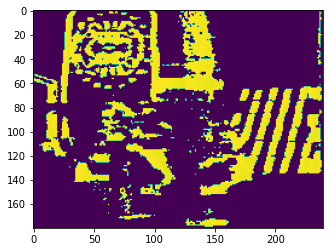

In [53]:
plt.imshow(sampled_img[:,:,1])

In [35]:
sampled_diff = np.full(sampled_img[:,:,1].shape, -1.0)
for y in range(sampled_diff.shape[0]):
    for x in range(sampled_diff.shape[1] -1):
        if sampled_img[y,x+1,1] == 0:
            continue
        if sampled_img[y,x,1] <= sampled_img[y,x+1,1]:
            continue
        sampled_diff[y, x] = np.exp(sampled_img[y,x,1] - sampled_img[y,x+1,1])

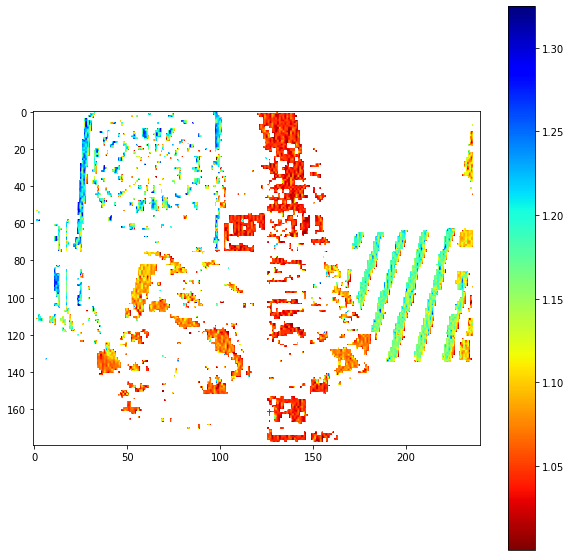

In [39]:
plt.figure(figsize=(10, 10))
sampled_diff_m = ma.masked_where(np.logical_or(sampled_diff <= 0, sampled_diff>1.325), sampled_diff)
#sampled_diff_m = ma.masked_where(sampled_diff <= 0, sampled_diff)

m = plt.imshow(sampled_diff_m, cmap="jet_r")
plt.colorbar(mappable=m)